In [1]:
import collections
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.font_manager
from scipy.stats import ks_2samp
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import forestci as fci

Failed to import duecredit due to No module named 'duecredit'


In [2]:
signal = pd.read_csv("resonances0.txt", delim_whitespace=True)
test_data = pd.read_csv("test.txt", delim_whitespace=True)
test_data = test_data[['Z','A']]
arr_test_data = test_data.values.reshape(-1,2)
test_data_inc = test_data[['A']]+1
arr_test_data_inc = test_data_inc.values.reshape(-1,1)

In [3]:
# Even-Odd residual nuclei

signaleven = signal[signal['Z'] % 2 == 0]
e1filter = signaleven[signaleven['A'] % 2 == 0] # Selecting only even data

# Odd-Even residual nuclei

signalodd = signal[signal['Z'] % 2 != 0]
e2filter = signalodd[signalodd['A'] % 2 == 0]

efilter = pd.concat([e1filter,e2filter])
efilter = efilter.sort_values(by=['Z'])

x = efilter[['Z','A']]
y = efilter[['D0','dD']] # Reshaping data
arr_x = x.values.reshape(-1,2)
arr_y = y.values.reshape(-1,2)
arr_y_pred, arr_y_err = np.hsplit(arr_y,2)
arr_y_pred = arr_y_pred.ravel()

X_train, X_test, y_train, y_test = train_test_split(arr_x, arr_y, test_size=0.2, random_state=11) # Splitting data into 80% training and 20% testing


X_train_inc = pd.DataFrame(X_train, columns=['Z','A'])
X_train_inc['A'] = X_train_inc['A'] + 1
arr_X_train_inc = X_train_inc.values.reshape(-1,2)

X_test_inc = pd.DataFrame(X_test, columns=['Z','A'])
X_test_inc['A'] = X_test_inc['A'] + 1
arr_X_test_inc = X_test_inc.values.reshape(-1,2)

y_train, y_train_dd = np.hsplit(y_train,2)
y_test, y_test_dd = np.hsplit(y_test,2)

y_train = y_train.ravel()
y_test = y_test.ravel()
y_test_dd = y_test_dd.ravel()

rfe = RandomForestRegressor(n_estimators=500,max_depth=50,random_state=10,max_features=2) # Building RF
rfe.fit(X_train,y_train)
score=rfe.score(X_train,y_train)

y_pred = rfe.predict(X_test)

rf_err = abs(fci.random_forest_error(rfe,X_train,X_test,calibrate=False)) # RF Errors

#Even-Odd Residual Nucleus experimental data

ee_data = test_data[test_data['Z'] % 2 == 0]
e1_data = ee_data[ee_data['A'] % 2 == 0] 

#Odd-Even Residual Nucleus experimental data

oo_data = test_data[test_data['Z'] % 2 != 0] 
e2_data = oo_data[oo_data['A'] % 2 == 0]

testfilter = pd.concat([e1_data,e2_data])
print(testfilter)
# testfilter = testfilter.sort_values(by=['Z'])

e_data = testfilter.values.reshape(-1,2)

test_data_inc = testfilter[['A']]+1
arr_test_data_inc = test_data_inc.values.reshape(-1,1)
arr_test_data_inc = arr_test_data_inc.ravel()


ye_pred = rfe.predict(e_data) # Prediciton of unknown data set
rfe_err = abs(fci.random_forest_error(rfe,X_train,e_data,calibrate=False)) # Errors of unkown data set
mse = mean_squared_error(y_test, y_pred)

     Z   A
1   23  50
2   25  52
3   27  56
4   27  58
5   29  60
7   29  62
8   29  64
11  31  64
12  31  66
13  31  68
14  33  70
15  33  72
16  33  74
17  39  84
19  39  88


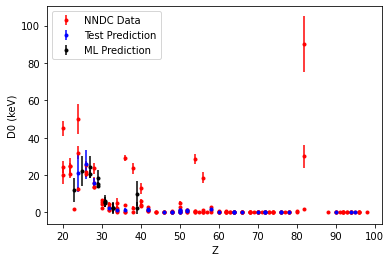

In [4]:
# Plotting

plt.errorbar(efilter['Z'],efilter['D0'],yerr=efilter['dD'],fmt='o',markersize=3, color='red',label='NNDC Data')
plt.errorbar(X_test[:,0],y_pred,yerr=np.sqrt(rf_err),fmt='o',markersize=3, color='blue',label='Test Prediction')
plt.errorbar(e_data[:,0],ye_pred,yerr=np.sqrt(rfe_err),fmt='o',markersize=3, color='black',label='ML Prediction')

#plt.fill_between(X_test[:,0], y_pred - np.sqrt(rf_err), y_pred + np.sqrt(rf_err), alpha=0.5, edgecolor='#1B2ACC', facecolor='#089FFF',label='ML Error')
#plt.scatter(X_test[:,0],y_pred,s=3,label='ML Prediction')

#plt.xlim(21,41)
#plt.ylim(-5,80)

plt.legend()
plt.xlabel("Z")
plt.ylabel("D0 (keV)")
plt.show()

In [5]:
# total_errs = [np.sqrt(rf_err[i] + float(y_test_dd[i])**2) for i in np.arange(len(X_test))]
ratio = [round(y_pred[i] / y_test[i],4) for i in np.arange(len(y_pred))]
ratio_err = [round(ratio[i]*(np.sqrt(rf_err[i] / y_pred[i]**2 + (float(y_test_dd[i]) / y_test[i])**2)),4) for i in np.arange(len(y_pred))]

In [6]:
with open("data_asymm.txt","w") as f:
    f.write('# Basic Learning Model - Showing Test Case of Asymmetric Nuclei - Score: {0} - MSE: {1} \n'.format(round(score,4),round(mse,4)))
    f.write('#Z   A   D0   dD   mlD0   mlDd   mlD0/D0   d(mlD0/D0) \n')
    for i in range(0, len(y_pred)):
        f.write("{0}   {1}   {2}   {3}   {4}   {5}    {6}    {7}\n".format(arr_X_test_inc[i,0],arr_X_test_inc[i,1],y_test[i],y_test_dd[i],round(y_pred[i],4),round(np.sqrt(rf_err[i]),4),ratio[i],ratio_err[i]))

In [7]:
rfe.fit(arr_x,arr_y_pred)
test_score = rfe.score(arr_x,arr_y_pred)
ye_pred = rfe.predict(e_data) # Prediciton of unknown data set
rfe_err = abs(fci.random_forest_error(rfe,arr_x,e_data,calibrate=False)) # Errors of unkown data set

In [8]:
with open("data_asymm_test.txt","w") as f:
    f.write('# Basic Learning Model - Calculating unknown symmetric test case - Score:{0} \n'.format(round(test_score,4)))
    f.write('#Z   A   mlD0   mlDd \n')
    for i in range(0, len(ye_pred)):
        f.write("{0}   {1}   {2}   {3}\n".format(e_data[i,0],arr_test_data_inc[i],round(ye_pred[i],4),round(np.sqrt(rfe_err[i]),4)))